In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

## 1. Forward diffusion, and a little bit of stochastic processes review

The first few functions are used to forward simulate 1D diffusion (although `forward_SDE_simulation` can be used to simulate more general SDEs). The last function outputs the analytic transition probability for 1D diffusion, which we can use to validate our simulations.
1. $$\dot{x} = f(x, t) + g(x, t) \ \eta(t)$$

2. $$x(t + \Delta t) = x(t) + f(x(t), t) \Delta t + g(x, t) \sqrt{\Delta t} \ r$$


In [5]:
# Simulate SDE with drift function f and noise amplitude g for arbitrary number of steps
def forward_SDE_simulation(x0, nsteps, dt, f, g, params):

  # Initialize time and a stochastic trajectory
  t = 0
  x_traj = np.zeros((nsteps + 1, *x0.shape))
  print(f'x_traj shape:{x_traj.shape}')
  x_traj[0] = np.copy(x0)


  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    random_normal = np.random.randn(*x0.shape)        # standard normal random number
    # eq: 2
    x_traj[i+1] = x_traj[i] + f(x_traj[i], t, params)*dt + g(x_traj[i], t, params)*np.sqrt(dt)*random_normal
    t = t + dt

  return x_traj


# Drift function for diffusion (returns zeros)
def f_diff_simple(x, t, params):
  """  The function $f(x, t)$ is the *drift* term, and describes how the average value of $x(t)$ evolves with time.
  
  Args:
      x (_type_): _description_
      t (_type_): _description_
      params (_type_): _description_

  Returns:
      _type_: _description_
  """
  return np.zeros((*x.shape,))


# Noise amplitude for diffusion (constant)
def g_diff_simple(x, t, params):
  """The term involving $g(x, t)$ is the *noise* or *diffusion* term, and describes stochastic fluctuations in the value of $x(t)$. 

  Args:
      x (_type_): _description_
      t (_type_): _description_
      params (_type_): _description_

  Returns:
      _type_: _description_
  """
  sigma = params['sigma']
  return sigma*np.ones((*x.shape,))


# Exact transition probability for 1D diffusion
def transition_probability_diffusion_exact(x, t, params):
  x0, sigma= params['x0'], params['sigma']

  pdf = norm.pdf(x, loc=x0, scale=np.sqrt((sigma**2)*t))  # pdf of normal distribution with mean x0 and variance (sigma^2)*t
  return pdf

In [3]:
"Parametars"

sigma = 1         # noise amplitude for 1D diffusion

num_samples = 1000
x0 = np.zeros(num_samples)    # initial condition for diffusion


nsteps = 2000      # number of simulation steps
dt = 0.001          # size of small time steps 
T = nsteps*dt
t = np.linspace(0, T, nsteps + 1)


params = {'sigma': sigma, 'x0':x0, 'T':T}

In [4]:
x_traj = forward_SDE_simulation(x0, nsteps, dt, f_diff_simple, g_diff_simple, params)

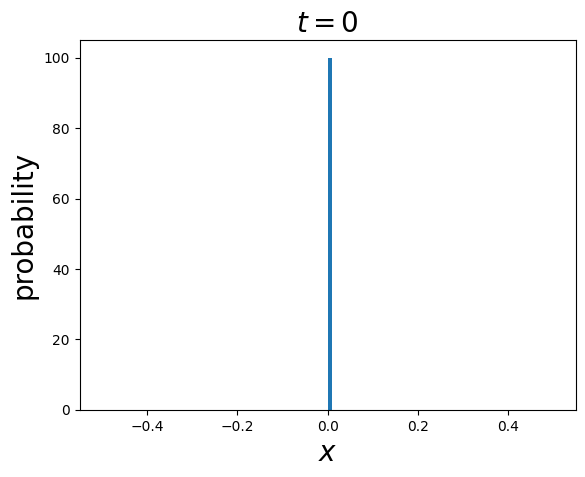

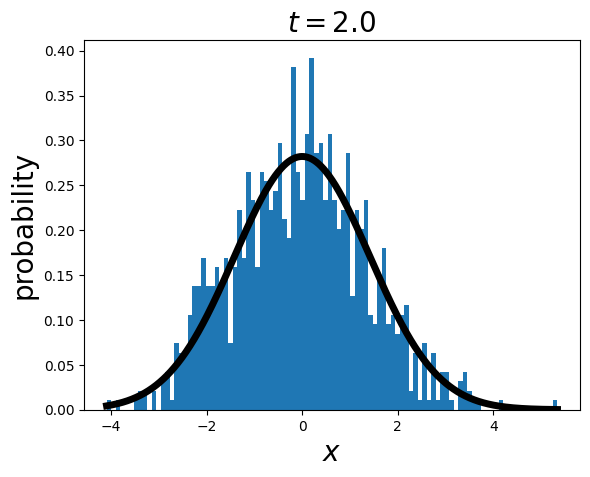

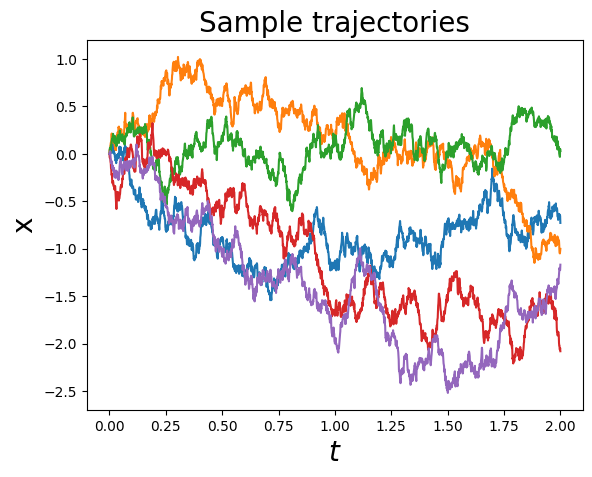

In [6]:
# Plot initial distribution (distribution before diffusion)
plt.hist(x_traj[0], density=True, bins=100)
plt.title("$t = 0$", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Compute exact transition probability 
x_f_min, x_f_max = np.amin(x_traj[-1]), np.amax(x_traj[-1])
num_xf = 1000
x_f_arg = np.linspace(x_f_min, x_f_max, num_xf)
pdf_final = transition_probability_diffusion_exact(x_f_arg, T, params)


# Plot final distribution (distribution after diffusion)
plt.hist(x_traj[-1], bins=100, density=True)
plt.plot(x_f_arg, pdf_final, color='black', linewidth=5)
plt.title("$t = $"+str(T), fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Plot trajectories
sample_trajectories = [0, 1, 2, 3, 4]
for s in sample_trajectories:
  plt.plot(t, x_traj[:,s])
plt.title("Sample trajectories", fontsize=20)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("x", fontsize=20)
plt.show()

## 2. Reverse diffusion

it turns out that it is mathematically straightforward to define the time-reverse of a stochastic process governed by an SDE. The time-reversed process is *itself* a stochastic process governed by an SDE, whose probability density evolves in time according to a Fokker-Planck equation.

$$x(t - \Delta t) = x(t) - \frac{(x_0 - x)}{t} \Delta t + \sigma \sqrt{\Delta t} \ r \ .$$

In [10]:
# Drift function for a reverse process. More general than 1D diffusion.
def f_diff_simple_rev(x, t, params):
    T = params['T']
    return - f_diff_simple(x, T-t, params) + (g_diff_simple(x, T-t, params)**2)*score(x, T-t, params)


# Noise function for 1D diffusion (constant)
def g_diff_simple_rev(x, t, params):
    sigma = params['sigma']
    return sigma*np.ones(len(x))
       

# The score function for 1D diffusion from a point source. Score = grad log p(x,t)
def score(x, t, params):
    x0 = params['x0']
    sigma = params['sigma']
    
    score = (x0 - x)/((sigma**2)*(t))
    
    return score

In [11]:
sigma = 1         # noise amplitude for 1D diffusion

num_samples = 1000
x0 = np.zeros(num_samples)    # initial condition for diffusion


nsteps = 2000      # number of simulation steps
dt = 0.001          # size of small time steps 
T = nsteps*dt
t = np.linspace(0, T, nsteps + 1)


params = {'sigma': sigma, 'x0':x0, 'T':T}

In [12]:
x_traj = forward_SDE_simulation(x0, nsteps, dt, f_diff_simple, g_diff_simple, params)
x_traj_rev = forward_SDE_simulation(x_traj[-1], nsteps, dt, f_diff_simple_rev, g_diff_simple_rev, params)

x_traj shape:(2001, 1000)
x_traj shape:(2001, 1000)


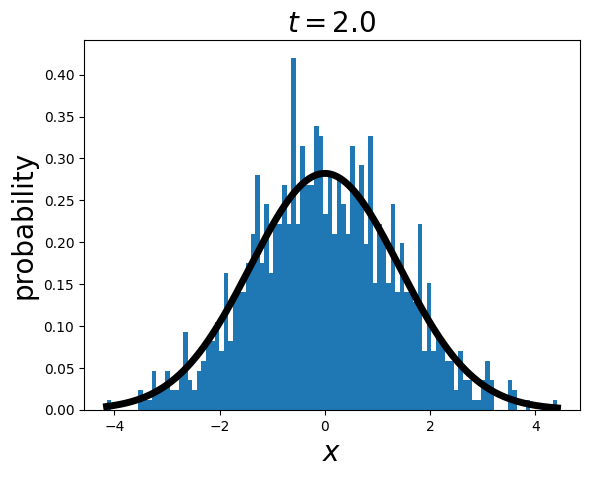

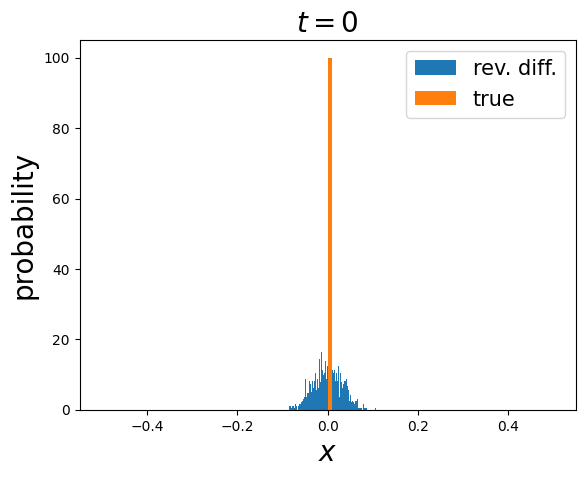

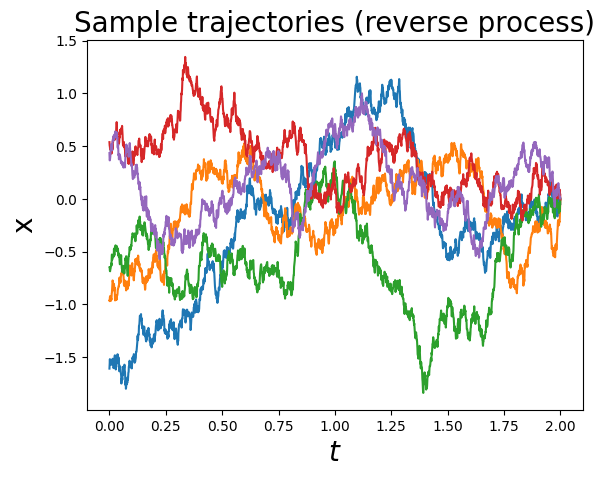

In [13]:
# Compute exact transition probability 
x_f_min, x_f_max = np.amin(x_traj[-1]), np.amax(x_traj[-1])
num_xf = 1000
x_f_arg = np.linspace(x_f_min, x_f_max, num_xf)
pdf_final = transition_probability_diffusion_exact(x_f_arg, T, params)


# Plot final distribution (distribution after diffusion / before reverse diffusion)
plt.hist(x_traj[-1], bins=100, density=True)
plt.plot(x_f_arg, pdf_final, color='black', linewidth=5)
plt.title("$t = $"+str(T), fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.show()


# Plot initial distribution (distribution before diffusion / after reverse diffusion)
#fig, ax = plt.subplots(1, 2, width=)
plt.hist(x_traj_rev[-1], density=True, bins=100, label='rev. diff.')
plt.hist(x_traj[0], density=True, bins=100, label='true')

plt.title("$t = 0$", fontsize=20)
plt.xlabel("$x$", fontsize=20)
plt.ylabel("probability", fontsize=20)
plt.legend(fontsize=15)
plt.show()


# Plot some trajectories
sample_trajectories = [0, 1, 2, 3, 4]
for s in sample_trajectories:
  plt.plot(t, x_traj_rev[:,s])
plt.title("Sample trajectories (reverse process)", fontsize=20)
plt.xlabel("$t$", fontsize=20)
plt.ylabel("x", fontsize=20)
plt.show()